In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import time
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Ignore warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix

from geopy.geocoders import Nominatim

IMPORT AND VIEW DATA

In [3]:
# Step 2 : import data
df = pd.read_csv('https://raw.githubusercontent.com/GenieMak/VISN-8-DS/refs/heads/main/disease_symptoms_dataset.csv')

In [4]:
df.head(10)

,Disease,Age,Gender,Latitude,Longitude,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Severity
0,Common Cold,45,Male,42.387,-95.223,Runny nose,Sneezing,NaN,60.0,NaN
1,Flu,63,Female,41.722,-97.154,Fever,Cough,Fatigue,NaN,80.0
2,Bronchitis,27,Male,44.586,-96.781,Cough,Shortness of breath,NaN,NaN,70.0
3,Migraine,57,Female,43.251,-99.042,Headache,Nausea,NaN,NaN,90.0
4,Allergy,31,Male,45.129,-94.714,Itchy eyes,Skin rash,NaN,50.0,NaN
5,Flu,53,Female,47.837,-97.872,Cough,Shortness of breath,NaN,NaN,80.0
6,Common Cold,22,Male,48.295,-97.349,Runny nose,Sneezing,NaN,60.0,NaN
7,Migraine,35,Female,44.903,-99.937,Headache,Nausea,NaN,NaN,90.0
8,Allergy,68,Male,42.804,-94.554,Itchy eyes,Skin rash,NaN,50.0,NaN
9,Bronchitis,47,Female,49.168,-96.209,Cough,Shortness of breath,NaN,NaN,70.0


In [5]:
df.columns

Index(['Disease', 'Age', 'Gender', 'Latitude', 'Longitude', 'Symptom_1',
       'Symptom_2', 'Symptom_3', 'Symptom_4', 'Severity'],
      dtype='object')

Check Data Quality and Preview Volume by Distinct Values

In [6]:
pd.set_option('display.max_rows', None)
#pd.reset_option(display.max_rows')

In [7]:
df.shape #300+ symptom3, 4 nulls; Severity null in over 200 instances

(790, 10)

In [8]:
df.info()
#Will use Age, Gender, Location Type, Symptom_1-2-3 Combined, and Severity (5 features, 6)
#Will drop features with more than 50% nulls (Symptom 4 is numeric and cant be combined with Symptom 1-3 anyway)
#Will combine lat/long into one feature: rural vs city (correlates to proximity to groceries, amenities, and healthcare))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Disease    790 non-null    object 
 1   Age        790 non-null    int64  
 2   Gender     790 non-null    object 
 3   Latitude   790 non-null    float64
 4   Longitude  790 non-null    float64
 5   Symptom_1  790 non-null    object 
 6   Symptom_2  784 non-null    object 
 7   Symptom_3  486 non-null    object 
 8   Symptom_4  269 non-null    float64
 9   Severity   521 non-null    float64
dtypes: float64(4), int64(1), object(5)
memory usage: 61.8+ KB


In [9]:
df['Disease'].value_counts() #sorted by desc count
# very small sampling of each disease.216 diseases total between 790 rows. 
# Only 5 diseases have >= 10 rows each. Migraine has 22 occurences

Disease
Migraine                                           22
Bronchitis                                         15
Allergy                                            12
Flu                                                12
Common Cold                                        10
Gout                                                8
Celiac Disease                                      8
Osteoarthritis                                      8
Hypothyroidism                                      8
Asthma                                              8
Pneumonia                                           8
Hemorrhoids                                         8
Sleep Apnea                                         7
Ulcerative Colitis                                  7
Depression                                          7
Eczema                                              7
Endometriosis                                       7
Melanoma                                            7
Osteoporosis        

In [10]:
df['Disease'].value_counts().sort_index() #sort alphabetically
#Disease Categorizations are really granular
# Would be helpful to join to a crosswalk that could broaden these specific diagnoses to broader diagnoses
# FOR THE SAKE OF TIME, WILL LIMIT DISEASES FOR CLASSIFICATION TO THOSE WITH >= 10 ROWS EACH (COMMON MINIMUM FOR RELIABLE PERFORMANCE)

Disease
ADHD (Attention Deficit Hyperactivity Disorder)     5
Acid Reflux                                         4
Acne                                                6
Acoustic Neuroma                                    1
Agoraphobia                                         1
Alcoholism                                          5
Allergic Rhinitis                                   5
Allergy                                            12
Alzheimer's Disease                                 6
Amyotrophic Lateral Sclerosis (ALS)                 1
Anemia                                              7
Angina                                              1
Ankylosing Spondylitis                              1
Anorexia Nervosa                                    5
Anxiety Disorder                                    5
Aplastic Anemia                                     1
Appendicitis                                        7
Arthritis                                           6
Asthma              

PARSE OUT USABLE DATA

In [11]:
min_row_count = 10
filtered_df_dat = df.groupby('Disease').filter(lambda x: len(x) >= min_row_count) 
filtered_df_dat.head()
#filtered_df['Disease'].value_counts()

,Disease,Age,Gender,Latitude,Longitude,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Severity
0,Common Cold,45,Male,42.387,-95.223,Runny nose,Sneezing,NaN,60.0,NaN
1,Flu,63,Female,41.722,-97.154,Fever,Cough,Fatigue,NaN,80.0
2,Bronchitis,27,Male,44.586,-96.781,Cough,Shortness of breath,NaN,NaN,70.0
3,Migraine,57,Female,43.251,-99.042,Headache,Nausea,NaN,NaN,90.0
4,Allergy,31,Male,45.129,-94.714,Itchy eyes,Skin rash,NaN,50.0,NaN


In [12]:
filtered_df_dat.shape

(71, 10)

In [13]:
#Categorical describe
filtered_df_dat[['Disease','Symptom_1','Symptom_2','Symptom_3']].head()

,Disease,Symptom_1,Symptom_2,Symptom_3
0,Common Cold,Runny nose,Sneezing,NaN
1,Flu,Fever,Cough,Fatigue
2,Bronchitis,Cough,Shortness of breath,NaN
3,Migraine,Headache,Nausea,NaN
4,Allergy,Itchy eyes,Skin rash,NaN


In [14]:
# Group by Disease and count occurrences
disease_counts = filtered_df_dat.groupby('Disease').size().reset_index(name='Counts')

# Sort by Disease and then by Counts in descending order 
sorted_disease_counts = disease_counts.sort_values(by=['Counts', 'Disease'], ascending=[False, True]) 

print(sorted_disease_counts)

       Disease  Counts
4     Migraine      22
1   Bronchitis      15
0      Allergy      12
3          Flu      12
2  Common Cold      10


In [15]:
#Wholistic view of impact Symptoms has on these 5 diseases
df_symptoms_melted = filtered_df_dat[['Symptom_1','Symptom_2','Symptom_3']].melt(value_name='Symptom', var_name='Symptom_Type')
df_symptoms_combined = df_symptoms_melted.drop(columns=['Symptom_Type']).dropna(subset=['Symptom']).reset_index(drop=True)
symptom_counts = df_symptoms_combined['Symptom'].value_counts()
print(symptom_counts)
#Note: prior to filtering ~45 symptoms had >= 10 rows each
#Now we have 12 distinct symptoms

Symptom
Cough                   27
Nausea                  22
Headache                20
Shortness of breath     20
Itchy eyes              12
Skin rash               12
Runny nose              10
Sneezing                10
Fever                    7
Fatigue                  7
Severe headache          2
Sensitivity to light     2
Name: count, dtype: int64


Explore Filtered Data for Analysis

In [16]:
#Combine symptoms into one column sorted alphabetically
filtered_df_dat['Combined_Symptoms']=filtered_df_dat[['Symptom_1','Symptom_2','Symptom_3']].apply(lambda x: ', '.join(sorted(x.dropna().astype(str))), axis=1)

In [17]:
# Drop original symptom column
filtered_df = filtered_df_dat.drop(columns=['Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4'])

In [18]:
filtered_df.sort_values(['Disease','Combined_Symptoms'])

,Disease,Age,Gender,Latitude,Longitude,Severity,Combined_Symptoms
4,Allergy,31,Male,45.129,-94.714,NaN,"Itchy eyes, Skin rash"
8,Allergy,68,Male,42.804,-94.554,NaN,"Itchy eyes, Skin rash"
14,Allergy,31,Male,45.129,-94.714,NaN,"Itchy eyes, Skin rash"
18,Allergy,68,Male,42.804,-94.554,NaN,"Itchy eyes, Skin rash"
21,Allergy,25,Female,42.975,-98.521,NaN,"Itchy eyes, Skin rash"
26,Allergy,50,Male,48.061,-97.407,NaN,"Itchy eyes, Skin rash"
34,Allergy,31,Male,45.129,-94.714,NaN,"Itchy eyes, Skin rash"
38,Allergy,68,Male,42.804,-94.554,NaN,"Itchy eyes, Skin rash"
41,Allergy,25,Female,42.975,-98.521,NaN,"Itchy eyes, Skin rash"
46,Allergy,50,Male,48.061,-97.407,NaN,"Itchy eyes, Skin rash"


In [19]:
#Numerical describe
filtered_df[['Age','Severity']].describe()
#Prior to filtering
#Range ages 5-75, most between 35 and 55, normally distrb
#Range symptom 4 (temp??) 50-95, most between 70 and 80, left skewed
#Range severity 50-95, most between 75 and 85, normally distrb

#Post to filtering
#Range ages 22-68, most between 31 and 54, normally distrb
#Range symptom 4 (temp??) 50-80, most between 50 and 60, severely right skewed
#Range severity 70-90, most between 70-90, normally distrb

,Age,Severity
count,71.000000,44.000000
mean,43.084507,80.000000
std,13.309230,8.352691
min,22.000000,70.000000
25%,31.000000,70.000000
50%,45.000000,80.000000
75%,54.000000,90.000000
max,68.000000,90.000000


LOCATION ATTRIBUTES

In [20]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

# Initialize Nominatim API
#geolocator = Nominatim(user_agent="geoapiExercises")
geolocator = Nominatim(user_agent="my_custom_user_agent")

In [21]:
filtered_df.head()

,Disease,Age,Gender,Latitude,Longitude,Severity,Combined_Symptoms
0,Common Cold,45,Male,42.387,-95.223,NaN,"Runny nose, Sneezing"
1,Flu,63,Female,41.722,-97.154,80.0,"Cough, Fatigue, Fever"
2,Bronchitis,27,Male,44.586,-96.781,70.0,"Cough, Shortness of breath"
3,Migraine,57,Female,43.251,-99.042,90.0,"Headache, Nausea"
4,Allergy,31,Male,45.129,-94.714,NaN,"Itchy eyes, Skin rash"


In [22]:
#Fn to get country and locality type from lat long

def get_location_info(lat, lon):
    try:
        location = geolocator.reverse((lat, lon), exactly_one=True) 
        address = location.raw['address']
        country = address.get('country',' ')
        country_code = address.get('country_code',' ')
        
        #locality = (address.get('city', '') or address.get('town', '') or address.get('village', '') 
        #            or address.get('hamlet', '') or address.get('suburb', '')) 
        locality_type = ('City' if 'city' in address else
                         'Suburb' if 'suburb' in address else
                         'Town' if 'town' in address else 
                         'Village' if 'village' in address else 
                         'Hamlet' if 'hamlet' in address else  'Unknown')
        return pd.Series([address, country, country_code, locality_type])
    except GeocoderTimedOut:
        return pd.Series([None, None, None,None]) 

#for testing
#sample = filtered_df.sample(n=10, random_state=1)

# Apply fn
filtered_df[['address','country','country_code', 'locality_type']] = filtered_df.apply(lambda row: get_location_info(row['Latitude'], row['Longitude']), axis=1)

In [105]:
print(filtered_df[['Latitude', 'Longitude', 'country', 'country_code', 'locality_type']].head())

   Latitude  Longitude        country country_code locality_type
0    42.387    -95.223  United States           us        Hamlet
1    41.722    -97.154  United States           us       Unknown
2    44.586    -96.781  United States           us       Unknown
3    43.251    -99.042  United States           us       Unknown
4    45.129    -94.714  United States           us       Unknown


In [107]:
import folium

# Initialize a map centered around the mean latitude and longitude
m = folium.Map(location=[filtered_df['Latitude'].mean(), filtered_df['Longitude'].mean()], zoom_start=2)

# Add points to the map
for _, row in filtered_df.iterrows(): 
    folium.Marker(location=[row['Latitude'], row['Longitude']]).add_to(m)

# Save the map to an HTML file 
m.save("map.html") 

In [108]:
import plotly.express as px

# Create a scatter map
fig = px.scatter_geo(filtered_df, lat='Latitude', lon='Longitude')

# Update layout to improve visualization
fig.update_layout(title='Geographic Data Visualization', geo=dict(scope='world'))

# Show the map
fig.show()

In [25]:
filtered_df.head()

,Disease,Age,Gender,Latitude,Longitude,Severity,Combined_Symptoms,address,country,country_code,locality_type
0,Common Cold,45,Male,42.387,-95.223,NaN,"Runny nose, Sneezing","{'road': '280th Street', 'hamlet': 'Brook Moun...",United States,us,Hamlet
1,Flu,63,Female,41.722,-97.154,80.0,"Cough, Fatigue, Fever","{'road': 'Road 6', 'county': 'Colfax County', ...",United States,us,Unknown
2,Bronchitis,27,Male,44.586,-96.781,70.0,"Cough, Shortness of breath","{'road': '471st Avenue', 'municipality': 'Gran...",United States,us,Unknown
3,Migraine,57,Female,43.251,-99.042,90.0,"Headache, Nausea","{'road': 'Whetstone Township Highway', 'county...",United States,us,Unknown
4,Allergy,31,Male,45.129,-94.714,NaN,"Itchy eyes, Skin rash","{'road': '260th Street', 'county': 'Meeker Cou...",United States,us,Unknown


In [26]:
filtered_df2 = filtered_df.drop(['Latitude','Longitude','address','country_code'],axis=1)
filtered_df2.head()

,Disease,Age,Gender,Severity,Combined_Symptoms,country,locality_type
0,Common Cold,45,Male,NaN,"Runny nose, Sneezing",United States,Hamlet
1,Flu,63,Female,80.0,"Cough, Fatigue, Fever",United States,Unknown
2,Bronchitis,27,Male,70.0,"Cough, Shortness of breath",United States,Unknown
3,Migraine,57,Female,90.0,"Headache, Nausea",United States,Unknown
4,Allergy,31,Male,NaN,"Itchy eyes, Skin rash",United States,Unknown


In [27]:
filtered_df2.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 71 entries, 0 to 697
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Disease            71 non-null     object 
 1   Age                71 non-null     int64  
 2   Gender             71 non-null     object 
 3   Severity           44 non-null     float64
 4   Combined_Symptoms  71 non-null     object 
 5   country            71 non-null     object 
 6   locality_type      71 non-null     object 
dtypes: float64(1), int64(1), object(5)
memory usage: 4.4+ KB


In [28]:
filtered_df2.groupby(['country','locality_type']).size().reset_index(name='Counts')

,country,locality_type,Counts
0,Canada,Unknown,4
1,United States,Hamlet,6
2,United States,Unknown,55
3,United States,Village,6


In [29]:
#can't use locality type either
filtered_df2 = filtered_df2.drop(['locality_type'],axis=1)
filtered_df2.head()

,Disease,Age,Gender,Severity,Combined_Symptoms,country
0,Common Cold,45,Male,NaN,"Runny nose, Sneezing",United States
1,Flu,63,Female,80.0,"Cough, Fatigue, Fever",United States
2,Bronchitis,27,Male,70.0,"Cough, Shortness of breath",United States
3,Migraine,57,Female,90.0,"Headache, Nausea",United States
4,Allergy,31,Male,NaN,"Itchy eyes, Skin rash",United States


In [30]:
#categorical variables
filtered_df2.groupby(['Gender','country']).size().reset_index(name='Counts')

,Gender,country,Counts
0,Female,Canada,4
1,Female,United States,33
2,Male,United States,34


In [31]:
#can't use country either
filtered_df2 = filtered_df2.drop(['country'],axis=1)
filtered_df2.head()

,Disease,Age,Gender,Severity,Combined_Symptoms
0,Common Cold,45,Male,NaN,"Runny nose, Sneezing"
1,Flu,63,Female,80.0,"Cough, Fatigue, Fever"
2,Bronchitis,27,Male,70.0,"Cough, Shortness of breath"
3,Migraine,57,Female,90.0,"Headache, Nausea"
4,Allergy,31,Male,NaN,"Itchy eyes, Skin rash"


In [32]:
filtered_df2.shape

(71, 5)

In [33]:
filtered_df2.head()

,Disease,Age,Gender,Severity,Combined_Symptoms
0,Common Cold,45,Male,NaN,"Runny nose, Sneezing"
1,Flu,63,Female,80.0,"Cough, Fatigue, Fever"
2,Bronchitis,27,Male,70.0,"Cough, Shortness of breath"
3,Migraine,57,Female,90.0,"Headache, Nausea"
4,Allergy,31,Male,NaN,"Itchy eyes, Skin rash"


MULTICLASS LOGISTIC REGRESSION
Needs to predict multiple categories. Has small sample size. Simpler algorithm

In [37]:
#Hot encode Gender and Combined_Symptoms
gender_encoded = pd.DataFrame()
gender_encoded['Gender'] = filtered_df2['Gender'].map({'Male': 1, 'Female': 0})
                                                                                                      
# Split Combined_Symptoms into individual symptoms
symptoms_split = filtered_df2['Combined_Symptoms'].str.get_dummies(sep=', ') 

# Drop the original columns that were split and encoded 
encoded_df2 = filtered_df2.drop(columns=['Combined_Symptoms','Gender']) 

# Join the one-hot encoded Gender and Symptoms
encoded_df2 = encoded_df2.join(symptoms_split).join(gender_encoded)


#Handling nulls of Severity by imputing with mean
imputer = SimpleImputer(strategy='mean')
encoded_df2['Severity'] = imputer.fit_transform(encoded_df2[['Severity']])

In [43]:
encoded_df2.head()

,Disease,Age,Severity,Cough,Fatigue,Fever,Headache,Itchy eyes,Nausea,Runny nose,Sensitivity to light,Severe headache,Shortness of breath,Skin rash,Sneezing,Gender
0,Common Cold,45,80.0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,Flu,63,80.0,1,1,1,0,0,0,0,0,0,0,0,0,0
2,Bronchitis,27,70.0,1,0,0,0,0,0,0,0,0,1,0,0,1
3,Migraine,57,90.0,0,0,0,1,0,1,0,0,0,0,0,0,0
4,Allergy,31,80.0,0,0,0,0,1,0,0,0,0,0,1,0,1


ELIMINATE CORRELATED FEATURES ITERATIVELY

In [68]:
#Calc correlation coef (interest is within symptoms)
corr_dat =  encoded_df2.drop(['Disease','Age','Severity','Gender'],axis=1) #v1

#v2 combine 100% correlated columns
corr_dat['Fever_Fatigue']= corr_dat[['Fever', 'Fatigue']].mean(axis=1)
corr_dat = corr_dat.drop(['Fever', 'Fatigue'],axis=1)

corr_dat['SkinRash_ItchyEyes']= corr_dat[['Skin rash', 'Itchy eyes']].mean(axis=1)
corr_dat = corr_dat.drop(['Skin rash', 'Itchy eyes'],axis=1)

corr_dat['Sneezing_RunnyNose']= corr_dat[['Sneezing', 'Runny nose']].mean(axis=1)
corr_dat = corr_dat.drop(['Sneezing', 'Runny nose'],axis=1)

corr_dat['SevereHeadache_LightSensitivity']= corr_dat[['Severe headache', 'Sensitivity to light']].mean(axis=1)
corr_dat = corr_dat.drop(['Severe headache', 'Sensitivity to light'],axis=1)

corr_dat['Nausea_Headache']= corr_dat[['Nausea', 'Headache']].mean(axis=1)
corr_dat = corr_dat.drop(['Nausea', 'Headache'],axis=1)

corr_dat['ShortnBreath_Cough']= corr_dat[['Shortness of breath', 'Cough']].mean(axis=1)
corr_dat = corr_dat.drop(['Shortness of breath', 'Cough'],axis=1)

corr_dat.head()
#Notes after earlier correlation check was done
#Highly correlated feature pairs:   Fever + Fatigue (100%)  <--- 100% correlated meaning always together- will combine by averaging their values
#                                   Nausea + Headache (93%) <-- headache occurs less frequently and is also more subjective - Headache (remove in future iteration)
#                                Skin Rash + Itchy eyes (100%)  <--- 100% correlated meaning always together- will combine by averaging their values
#                                Sneezing + Runny Nose (100%) <--- 100% correlated meaning always together- will combine by averaging their values
#                                Severe headache + Sensitivity to light (100%)  <--- 100% correlated meaning always together- could combine by averaging their values, but severe headache could be subjective however these are known symptoms for migraines
#                                Shortness of Breath + Cough (80%)

,Fever_Fatigue,SkinRash_ItchyEyes,Sneezing_RunnyNose,SevereHeadache_LightSensitivity,Nausea_Headache,ShortnBreath_Cough
0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.5
2,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0


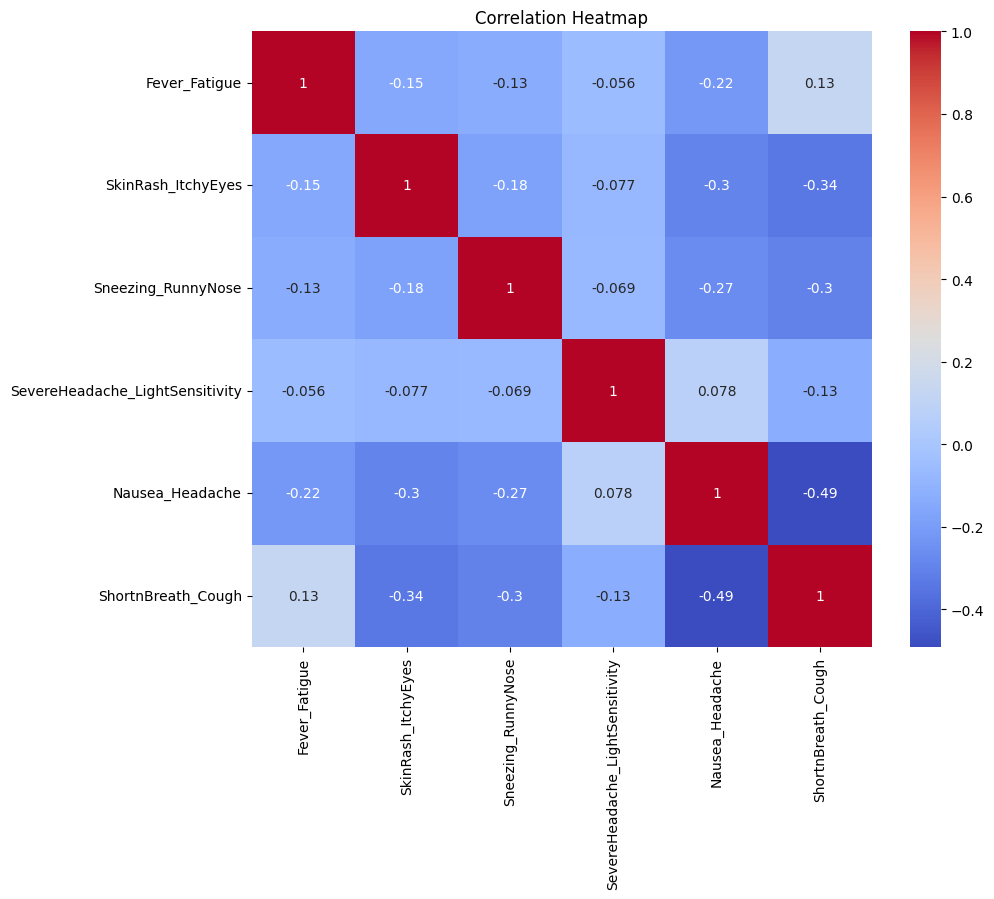

In [69]:
corr = corr_dat.corr()

#Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show() 

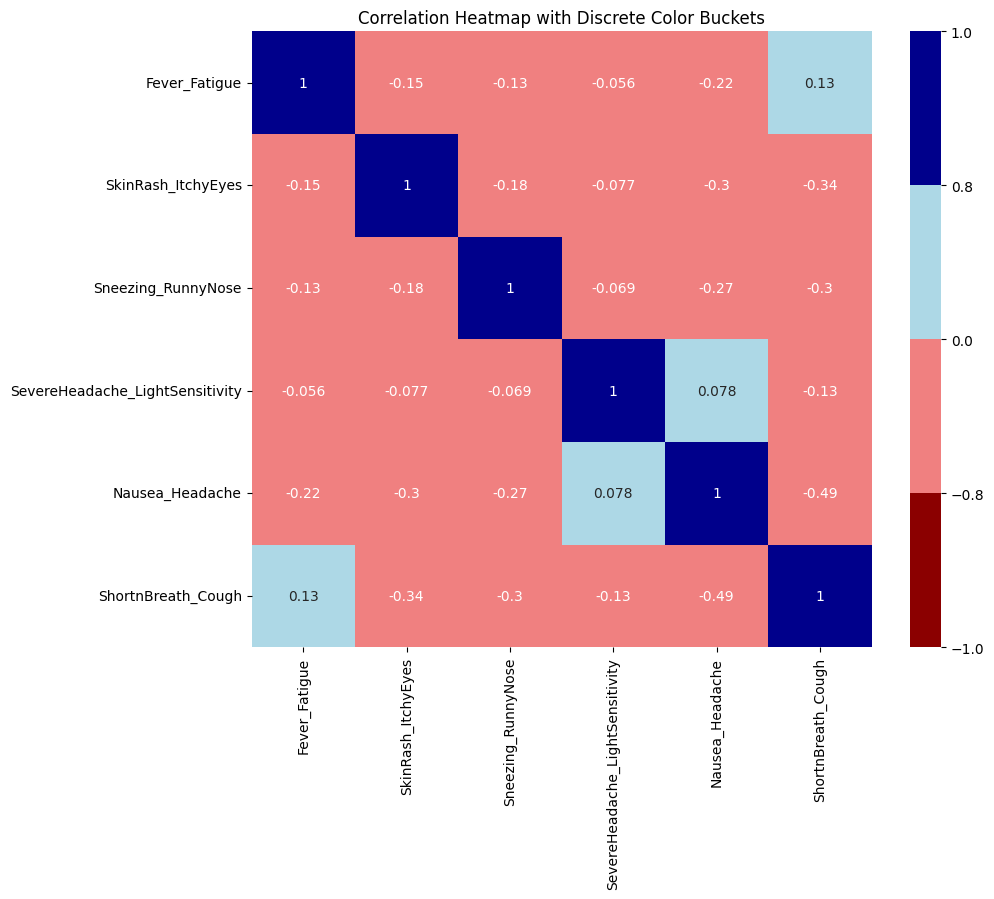

In [70]:
#Prefer discrete color bins and a clear threshold of abs = 0.8
bounds = [-1, -0.8, 0, 0.8, 1]
cmap = ListedColormap(['darkred', 'lightcoral', 'lightblue','darkblue'])
norm = BoundaryNorm(boundaries=bounds, ncolors=4)

# Plot the heatmap with discrete color bins 
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap=cmap, norm=norm, cbar_kws={'ticks': bounds}) 
plt.title('Correlation Heatmap with Discrete Color Buckets')
plt.show()

#Highly correlated feature pairs:
# ROUND 1:                 Fever + Fatigue (100%)
#                          Nausea + Headache (93%)
#                                Skin Rash + Itchy eyes (100%)
#                                Sneezing + Runny Nose (100%)
#                                Severe headache + Sensitivity to light (100%)
#                                Shortness of Breath + Cough (80%)

# ROUND 2:            None

In [72]:
# Function to calculate VIF (anything below 5 has low collinearity, 5-10 moderate, 10+ including infinite means high)
def calculate_vif(df): 
    vif_data = pd.DataFrame() 
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))] 
    return vif_data

# Initial VIF calculation
vif_data = calculate_vif(corr) 

print("VIF values of initial features:\n", vif_data)

VIF values of initial features:
                            feature  VIF
0                    Fever_Fatigue  inf
1               SkinRash_ItchyEyes  inf
2               Sneezing_RunnyNose  inf
3  SevereHeadache_LightSensitivity  inf
4                  Nausea_Headache  inf
5               ShortnBreath_Cough  inf


In [74]:
encoded_df2.head()

,Disease,Age,Severity,Cough,Fatigue,Fever,Headache,Itchy eyes,Nausea,Runny nose,Sensitivity to light,Severe headache,Shortness of breath,Skin rash,Sneezing,Gender
0,Common Cold,45,80.0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,Flu,63,80.0,1,1,1,0,0,0,0,0,0,0,0,0,0
2,Bronchitis,27,70.0,1,0,0,0,0,0,0,0,0,1,0,0,1
3,Migraine,57,90.0,0,0,0,1,0,1,0,0,0,0,0,0,0
4,Allergy,31,80.0,0,0,0,0,1,0,0,0,0,0,1,0,1


In [79]:
#Earlier version of code
encoded_df3 = encoded_df2

#Feature filtering looks good. Now Recombine narrowed down features with data
encoded_df3['Fever_Fatigue']= encoded_df2[['Fever', 'Fatigue']].mean(axis=1)
encoded_df3 = encoded_df3.drop(['Fever', 'Fatigue'],axis=1)

encoded_df3['SkinRash_ItchyEyes']= encoded_df3[['Skin rash', 'Itchy eyes']].mean(axis=1)
encoded_df3 = encoded_df3.drop(['Skin rash', 'Itchy eyes'],axis=1)

encoded_df3['Sneezing_RunnyNose']= encoded_df3[['Sneezing', 'Runny nose']].mean(axis=1)
encoded_df3 = encoded_df3.drop(['Sneezing', 'Runny nose'],axis=1)

encoded_df3['SevereHeadache_LightSensitivity']= encoded_df3[['Severe headache', 'Sensitivity to light']].mean(axis=1)
encoded_df3 = encoded_df3.drop(['Severe headache', 'Sensitivity to light'],axis=1)

encoded_df3['Nausea_Headache']= encoded_df3[['Nausea', 'Headache']].mean(axis=1)
encoded_df3 = encoded_df3.drop(['Nausea', 'Headache'],axis=1)

encoded_df3['ShortnBreath_Cough']= encoded_df3[['Shortness of breath', 'Cough']].mean(axis=1)
encoded_df3 = encoded_df3.drop(['Shortness of breath', 'Cough'],axis=1)

In [81]:
encoded_df3.head()

,Disease,Age,Severity,Gender,Fever_Fatigue,SkinRash_ItchyEyes,Sneezing_RunnyNose,SevereHeadache_LightSensitivity,Nausea_Headache,ShortnBreath_Cough
0,Common Cold,45,80.0,1,0.0,0.0,1.0,0.0,0.0,0.0
1,Flu,63,80.0,0,1.0,0.0,0.0,0.0,0.0,0.5
2,Bronchitis,27,70.0,1,0.0,0.0,0.0,0.0,0.0,1.0
3,Migraine,57,90.0,0,0.0,0.0,0.0,0.0,1.0,0.0
4,Allergy,31,80.0,1,0.0,1.0,0.0,0.0,0.0,0.0


In [82]:
encoded_df3.shape # no data lost

(71, 10)

In [83]:
# Features and target 
y = encoded_df3['Disease']
X = encoded_df3.drop(['Disease'],axis=1)


feature_names = X.columns

PREDICTION: One vs Rest

In [84]:
# Target variable 
# Split the data into training (80%) and testing (20%) sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) 

# Display the shapes of the resulting datasets 
print(f"Training Features Shape: {X_train.shape}") 
print(f"Testing Features Shape: {X_test.shape}") 
print(f"Training Target Shape: {y_train.shape}") 
print(f"Testing Target Shape: {y_test.shape}")

Training Features Shape: (53, 9)
Testing Features Shape: (18, 9)
Training Target Shape: (53,)
Testing Target Shape: (18,)


In [85]:
# Apply SMOTE to the training data 
smote = SMOTE(random_state=42) 
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [86]:
#scaler = StandardScaler()

scaler = MinMaxScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Can try both MinMaxScaler and StandardScaler, and compare performance of models

In [87]:
logR_ovr = LogisticRegression(multi_class='ovr')
logR_ovr.fit(X_train_res_scaled,y_train_res)
print("Score when multi_class='ovr':", logR_ovr.score(X_train_res_scaled,y_train_res))

Score when multi_class='ovr': 1.0


In [88]:
encoded_df3['Disease'].unique()

array(['Common Cold', 'Flu', 'Bronchitis', 'Migraine', 'Allergy'],
      dtype=object)

In [89]:
#predictions
y = y.astype(str)
y_test_pred = logR_ovr.predict(X_test_scaled).astype(str)

# Get the class order from the model 
class_labels = logR_ovr.classes_


#Confusion matrix and classification report
print("multi_class='ovr'\n")
print(confusion_matrix(y_test,y_test_pred,labels=class_labels))
print(classification_report(y_test,y_test_pred,labels=class_labels))

multi_class='ovr'

[[5 0 0 0 0]
 [0 3 0 0 0]
 [0 0 4 0 0]
 [0 0 0 3 0]
 [0 0 0 0 3]]
              precision    recall  f1-score   support

     Allergy       1.00      1.00      1.00         5
  Bronchitis       1.00      1.00      1.00         3
 Common Cold       1.00      1.00      1.00         4
         Flu       1.00      1.00      1.00         3
    Migraine       1.00      1.00      1.00         3

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



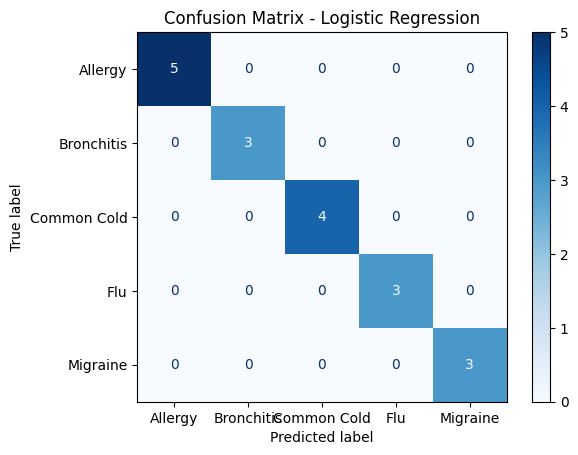

In [93]:
#PLOT of confusion matrix:
cm = confusion_matrix(y_test, y_test_pred, labels=class_labels) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues) 
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

RESULTS: 
Allergy: 5 of 5 correctly classified. 100% correctly recalled, f1 SCORE OF 1

Bronchitis: 3 of 3 correctly classified. 100% correctly recalled, f1 SCORE OF 1

Common Cold: 4 of 4 correctly classified. 100% correctly recalled, f1 SCORE OF 1

Flu: 3 of 3 correctly classified.  100% correctly recalled, f1 SCORE OF 1

Migraine: 3 of 3 correctly classified. 100% correctly recalled, f1 SCORE OF 1


Insights:
High Precision and Recall: The model shows high precision but due to too small of a sample size it is hard to test. 

FEATURE IMPORTANCE

In [94]:
# Extracting feature importance (coefficients) of the logistic regression model
coefficients = logR_ovr.coef_ 

# Get the class order from the model 
class_labels = logR_ovr.classes_


# Map coefficients to feature names
feature_importance = pd.DataFrame(coefficients, columns=feature_names, index=class_labels).transpose() 
feature_importance = feature_importance.transpose() 

# Display feature importance
print("\nFeature Importance:\n", feature_importance)


Feature Importance:
                   Age  Severity    Gender  Fever_Fatigue  SkinRash_ItchyEyes  \
Allergy      0.087401  0.044994  0.336578      -0.417012            3.433837   
Bronchitis   0.009447 -2.777861  0.391413      -0.900770           -0.681643   
Common Cold -0.178903  0.116095  1.191625      -0.308704           -1.031896   
Flu          0.346696  1.467190 -1.317041       2.359431           -0.783817   
Migraine    -0.381450  1.124131 -0.347702      -0.499887           -0.964843   

             Sneezing_RunnyNose  SevereHeadache_LightSensitivity  \
Allergy               -1.036793                        -0.085376   
Bronchitis            -0.725111                        -0.060016   
Common Cold            3.152807                        -0.114963   
Flu                   -0.550524                        -0.024245   
Migraine              -0.922062                         0.494291   

             Nausea_Headache  ShortnBreath_Cough  
Allergy            -0.918414         

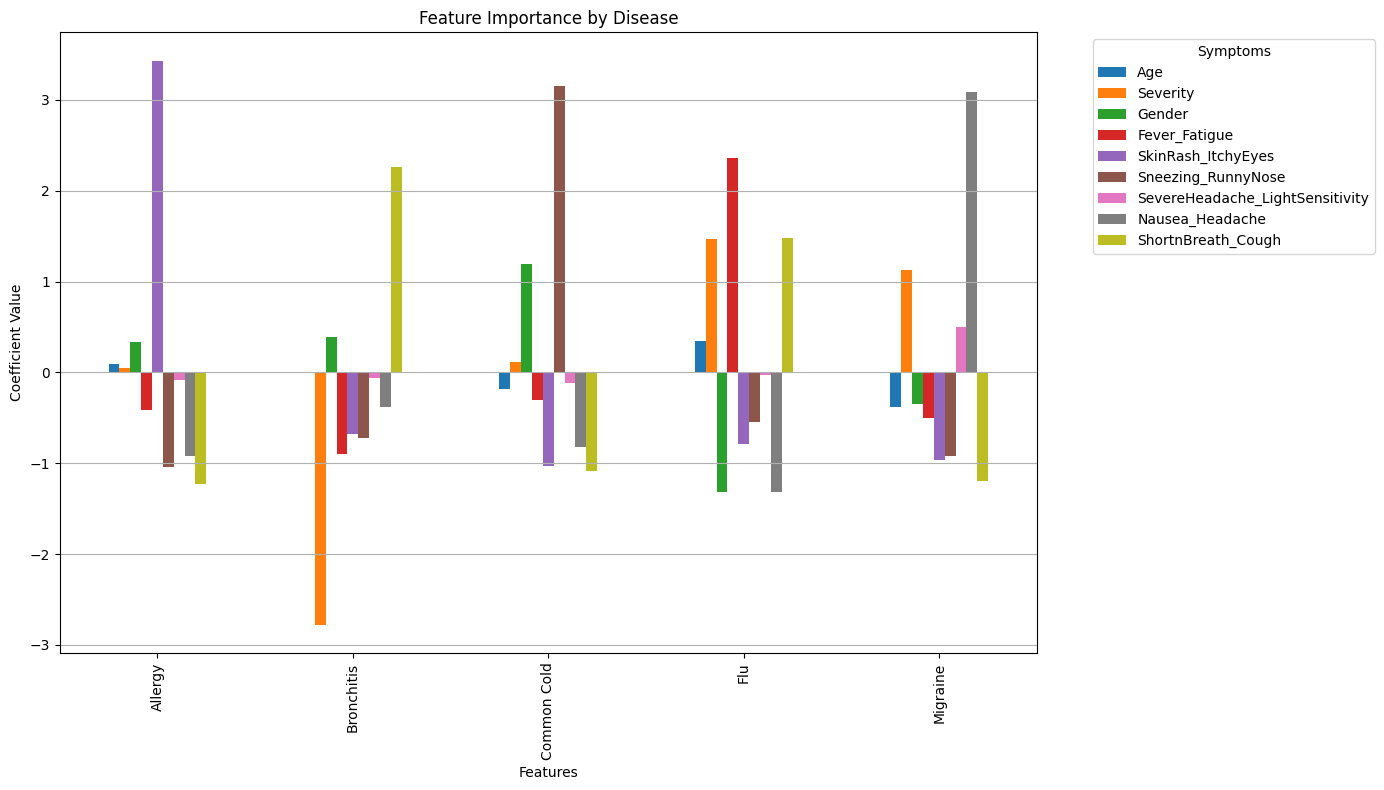

In [96]:
# Plotting Feature Importance for Each Disease
feature_importance.plot(kind='bar', figsize=(14, 8)) 
plt.title('Feature Importance by Disease')
plt.xlabel('Features')
plt.ylabel('Coefficient Value') 
plt.legend(title='Symptoms', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y') 
plt.tight_layout()
plt.show()

#STRONGEST ASSOCIATIONS (in comparison to other features)
#  SKIN RASH + ITCHY EYES ---> ALLERGY
#  ABSENCE OF LOW SEVERITY or  SHORTNESS OF BREATH + COUGH ---> BRONCHITIS
#  SNEEZING + RUNNY NOSE ---> COMMON COLD
#  FEVER + FATIGUE MOSTLY, but also High Severity, Shortness of Breath + Cough,
#                          If you're not Male (1), If you aren't claiming Nausea and Headache, ---> FLU
#  NAUSEA + HEADACHE --> MIGRAINE